In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import time
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# s_id is spider id and is also used for individual identification
# since we only have two individuals, the program will only use the first two elements from these arrays (s_id and colours)
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in s_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 4
s_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(0,0,0),(255,255,0),(255,0,0),(0,255,0),(255,255,255)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 51
offset = 35

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
# in this case, the range is wide because males vastly smaller than females
min_area = 5
max_area = 500

# kernel for erosion and dilation
# useful since thin spider limbs are sometimes detected as separate objects
kernel = np.ones((5,5),np.uint8)

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = True

# name of source video and paths
video = 'Tadpole'
input_vidpath = '/home/user/Documents/Vivek/tracktor/videos/toxtrac_videos/' + video + '.avi'
output_vidpath = '/home/user/Documents/Vivek/tracktor/output/toxtrac_videos/' + video + '.mp4'
output_filepath = '/home/user/Documents/Vivek/tracktor/output/toxtrac_videos/' + video + '.csv'
output_framesize = (800, 600)
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

In [8]:
## Start time
start = time.time()

## Path to source video
cap = cv2.VideoCapture(input_vidpath)

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = 1.0, fy = 1.0, interpolation = cv2.INTER_LINEAR)
        
        # Apply mask to aarea of interest
        mask = np.zeros(frame.shape)
        mask = cv2.rectangle(mask, (100, 30), (750,580), (255,255,255), -1)
        frame[mask ==  0] = 0
        
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        thresh = cv2.erode(thresh, kernel, iterations = 1)
        thresh = cv2.dilate(thresh, kernel, iterations = 1)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)

        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)

        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], s_id[i]])

        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last == this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y','id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

## End time and duration
end = time.time()
duration = end - start
print("--- %s seconds ---" %duration)

--- 45.310861587524414 seconds ---


## Plot tracks
The code below allows you to see individual tracks. By counting the number of jumps in the tracks, one can identify number of false detections.

In [4]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,1.0,120.481659,293.590112,A
1,1,1.0,719.333333,296.065934,B
2,2,1.0,125.500000,570.000000,C
3,3,1.0,469.122807,570.617544,D
4,4,2.0,120.911111,289.760684,A


In [5]:
for num,val in enumerate(np.unique(df['id'])):
    df.loc[df['id'] == val, 'id'] = num

df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,1.0,120.481659,293.590112,0
1,1,1.0,719.333333,296.065934,1
2,2,1.0,125.500000,570.000000,2
3,3,1.0,469.122807,570.617544,3
4,4,2.0,120.911111,289.760684,0


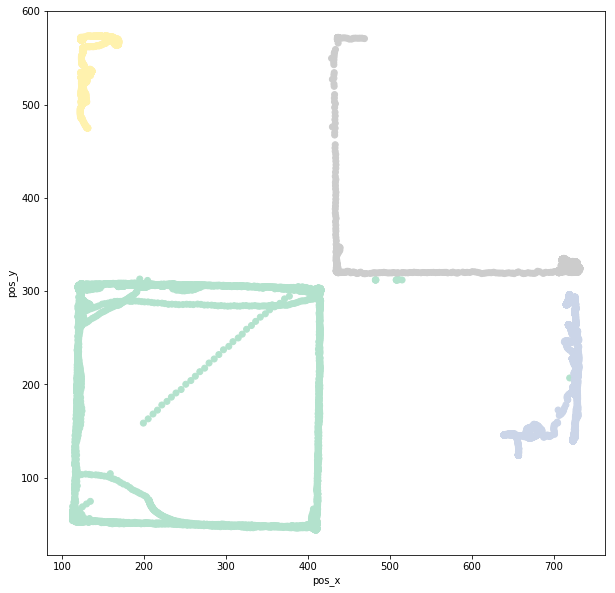

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'], cmap='Pastel2')
plt.xlabel('pos_x')
plt.ylabel('pos_y')
plt.show()